# Bayesian Neural Networks (Model definition, fitting and sampling)
***AM207 Final project Fall 2020: Supplemental Notebook:  Cox, Oramasionwu, Clark, Beerepoot, Rochon***

This notebook contains the implementation of Bayesian Neural Networks for the three datasets used in our experiments. Each BNN was implemented in the Keras-Tensorflow environment ([keras-tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras) ) using 'flipout' layers ([flipout](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout) , Wen et al 2018) to perform variational inference.

* All BNNs have the same architecture: 2 hidden layers with 30 nodes and relu activation, and 1 output layer with a single node and sigmoid activation. We explored other architectures but found that more complex architectures did not improve model accuracy.


* Priors for all model weights and biases were gaussian with $\mu=0$, and $\sigma= 0.1$. The variational distribution was in each case multivariate gaussian with a diagonal covariance matrix.


* After fitting, 1000 samples were drawn from each BNN and stored in such a way that the weights and biases from each sample could be transfered to a BNN of the same architecture but implemented with Autograd [autograd](https://github.com/HIPS/autograd), an automatic differentiation package compatible with our CLUE algorithm. Thus, training was done in the keras-tensorflow environment, and then transfer learning was used to run the BNN during the search for CLUEs. 


Links to models for specific datasets are below:
- [BNN 1](#BNN1): For the VAEAC-generated Synthetic Loan Dataset (3 featrues)
- [BNN 2](#BNN2): For the VAE-generated Augmented Synthetic Loan Dataset (5 features)
- [BNN 3](#BNN3): For the VAE-generated COMPAS Dataset (6 features)

**Note**: the section links above only work in Jupyter. On Colab use the built-in table-of-contents instead.

**Ref**: Yeming Wen, Paul Vicol, Jimmy Ba, Dustin Tran, and Roger Grosse. Flipout: Efficient Pseudo-Independent Weight Perturbations on Mini-Batches. In International Conference on Learning Representations, 2018. https://arxiv.org/abs/1803.04386

### Importing Packages

In [22]:
from autograd import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
%matplotlib inline
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
tfd = tfp.distributions
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
import base64
import pickle
import csv

### Setting Paths

In [23]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab. Mounting google drive...')
  from google.colab import drive
  drive.mount('/content/gdrive')
  base_path = '/content/gdrive/Shareddrives/AM207 - CLUE Final Project/_ForSubmission'
else:
  print('Not running on CoLab.')
  base_path = os.path.abspath("../")

Running on CoLab. Mounting google drive...
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
data_path = f"{base_path}/data"
parameter_path = f"{base_path}/model_parameters"

### Some Needed Functions

In [25]:
# load csv and unpickle
def load_file(name):
    with open(name, 'r') as csv_file:
        for line in csv_file:
            line = line.strip('\n')
            b64_str = line.split('|')[2]                    # take the pickled obj
            obj = pickle.loads(base64.b64decode(b64_str))   # retrieve
            return obj

# Some functions useful for sampling from the BNN posterior after fitting
def sample_weights_biases_from_layer(layer):
    mean_weights = np.array(layer.kernel_posterior.mean()).T.flatten()
    std_weights = np.array(layer.kernel_posterior.stddev()).T.flatten()
    weights_sample = multivariate_normal.rvs(mean=mean_weights, cov = np.diag(std_weights**2), size=1)
    
    mean_biases = np.array(layer.bias_posterior.mean()).T.flatten()
    std_biases = np.array(layer.bias_posterior.stddev()).T.flatten()
    biases_sample = multivariate_normal.rvs(mean=mean_biases, cov = np.diag(std_biases**2), size=1)
    
    if biases_sample.size == 1:
        biases_sample = np.array([biases_sample])
    if weights_sample.size == 1:
        weights_sample = np.array([weights_sample])
   
    return  np.concatenate([weights_sample, biases_sample])

def sample_weights_biases_from_model(model):
    wb = []
    for layer in model.layers:
        if 'flip' in layer.name:
            wb.append(sample_weights_biases_from_layer(layer))
    return np.concatenate(wb)

def generate_posterior_samples(model, num):
    samples = []
    for i in range(num):
        samples.append(sample_weights_biases_from_model(model))
    return np.array(samples)

### An Autograd Neural Network for use after weight transfer from Keras-Tensorflow BNNs

In [26]:
class Feedforward_flex:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params'],
                       'task': architecture['task']}
 
        # Calculating total number of weights + biases -> self.D
        H = self.params['H']
        num_H = len(H)
        self.num_H = num_H
        D_in = self.params['D_in']
        D_out = self.params['D_out']
        D_H = H
        self.D_H = D_H
        self.D = D_in*H[0] + H[0]
        for i in range(num_H -1):
            self.D += D_H[i] * H[i+1] + H[i+1]
        self.D += D_H[-1]*D_out + D_out
        self.task = self.params['task']
        
         # Initializing weights and biases
        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))
    
    
    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']
        D_H = self.D_H # *

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            self.N = x.shape[1]
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H[0] * D_in].T.reshape((-1, H[0], D_in))
        b = weights[H[0] * D_in:H[0] * D_in + H[0]].T.reshape((-1, H[0], 1))
        input = self.h(np.matmul(W, x) + b)
        # index = H * D_in + H
        index = H[0] * D_in + H[0]

        assert input.shape[1] == H[0]
        
        #additional hidden layers
        for i in range(self.num_H - 1): # *
            before = index
            W = weights[index:index + H[i+1] * D_H[i]].T.reshape((-1, H[i+1], D_H[i]))
            index += H[i+1] * D_H[i]
            b = weights[index:index + H[i+1]].T.reshape((-1, H[i+1], 1))
            index += H[i+1]
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H[i+1]        
            
        #output layer
        W = weights[index:index + H[-1] * D_out].T.reshape((-1, D_out, H[-1]))
        b = weights[index + H[-1] * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']
        if self.task=='classify':
            return 1 / (1 + np.exp(-output))
        return output
    
    
    def predict(self, weights, x):
        y = self.forward(weights, x)[0][0]
        if self.task == 'classify':
            return [0 if x < 0.5 else 1 for x in y]
        else:
            return y
    
    def predict_proba(self, weights, x ):
        if self.task == 'classify':
            return self.forward(weights, x)[0][0]
        else:
            print('Not trained on a classification task')

<a class='anchor' id='BNN1'></a>
### A BNN for the VAEAC-Generated Synthetic Loan Datset (3 features)

***Loading and looking at data (1000 datapoints, 3 features)***

In [27]:
fake_loan_3var_csv_path = f"{data_path}/FakeLoan_3var_generated/vaeac_generated_data.csv"
x = load_file(fake_loan_3var_csv_path).T
df_x = pd.DataFrame(x, columns=(['fico','term',  'pti',  'default']))
display(df_x.head())
train_y = x[:, 3]
train_x = x[:,0:3]

,fico,term,pti,default
0,-0.734066,-0.105739,1.362788,0.0
1,0.049061,1.268856,-1.035465,0.0
2,1.061171,0.604203,-0.868643,0.0
3,0.826416,-0.487354,1.002237,0.0
4,-1.113573,1.198829,0.015718,0.0


In [ ]:
train_x.shape

(1000, 3)

In [ ]:
train_y.shape

(1000,)

***Creating a BNN with  Keras in Tensorflow*** 

In [ ]:
# We learned the basics of how to build this with tensorflow probability layers from https://github.com/tensorflow/probability/blob/master/
# tensorflow_probability/examples/bayesian_neural_network.py
tfp.layers.default_mean_field_normal_fn

NUM_TRAIN_EXAMPLES = 1000

kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p)/
                        tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

model_loan = tf.keras.models.Sequential([
  tfp.layers.DenseFlipout(
      30, kernel_divergence_fn=kl_divergence_function, bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular=False),
      activation=tf.nn.relu, input_shape=(3,)),
  tfp.layers.DenseFlipout(
      30, kernel_divergence_fn=kl_divergence_function, bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular=False),
      activation=tf.nn.relu),
  tfp.layers.DenseFlipout(1, kernel_divergence_fn=kl_divergence_function, bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular=False),
      activation='sigmoid')
])

# Model compilation.
optimizer = tf.keras.optimizers.Adam(lr=.001)
# 
model_loan.compile(optimizer, loss='binary_crossentropy',
            metrics=['accuracy'])

model_loan.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_flipout_9 (DenseFlipou (None, 30)                240       
_________________________________________________________________
dense_flipout_10 (DenseFlipo (None, 30)                1860      
_________________________________________________________________
dense_flipout_11 (DenseFlipo (None, 1)                 62        
Total params: 2,162
Trainable params: 2,162
Non-trainable params: 0
_________________________________________________________________


***Training the BNN via Variational inference*** 

In [ ]:
history = model_loan.fit(x=train_x,
        y=train_y,
        batch_size=32,
        epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 634us/step - loss: 3.2710 - accuracy: 0.4260
Epoch 2/100
32/32 [==============================] - 0s 617us/step - loss: 3.0939 - accuracy: 0.9320
Epoch 3/100
32/32 [==============================] - 0s 628us/step - loss: 2.8664 - accuracy: 0.9340
Epoch 4/100
32/32 [==============================] - 0s 607us/step - loss: 2.7290 - accuracy: 0.9340
Epoch 5/100
32/32 [==============================] - 0s 658us/step - loss: 2.6742 - accuracy: 0.9340
Epoch 6/100
32/32 [==============================] - 0s 617us/step - loss: 2.6382 - accuracy: 0.9340
Epoch 7/100
32/32 [==============================] - 0s 841us/step - loss: 2.6042 - accuracy: 0.9340
Epoch 8/100
32/32 [==============================] - 0s 679us/step - loss: 2.5723 - accuracy: 0.9340
Epoch 9/100
32/32 [==============================] - 0s 660us/step - loss: 2.5375 - accuracy: 0.9340
Epoch 10/100
32/32 [==============================] - 0s 674us/step - loss: 2.5079 - accura

32/32 [==============================] - 0s 814us/step - loss: 0.8099 - accuracy: 0.9340
Epoch 82/100
32/32 [==============================] - 0s 855us/step - loss: 0.7902 - accuracy: 0.9340
Epoch 83/100
32/32 [==============================] - 0s 858us/step - loss: 0.7814 - accuracy: 0.9340
Epoch 84/100
32/32 [==============================] - 0s 780us/step - loss: 0.7704 - accuracy: 0.9340
Epoch 85/100
32/32 [==============================] - 0s 726us/step - loss: 0.7563 - accuracy: 0.9340
Epoch 86/100
32/32 [==============================] - 0s 772us/step - loss: 0.7486 - accuracy: 0.9330
Epoch 87/100
32/32 [==============================] - 0s 758us/step - loss: 0.7254 - accuracy: 0.9340
Epoch 88/100
32/32 [==============================] - 0s 709us/step - loss: 0.7258 - accuracy: 0.9340
Epoch 89/100
32/32 [==============================] - 0s 705us/step - loss: 0.7166 - accuracy: 0.9340
Epoch 90/100
32/32 [==============================] - 0s 740us/step - loss: 0.6998 - accuracy: 

***Plotting model loss and accuracy per epoch***

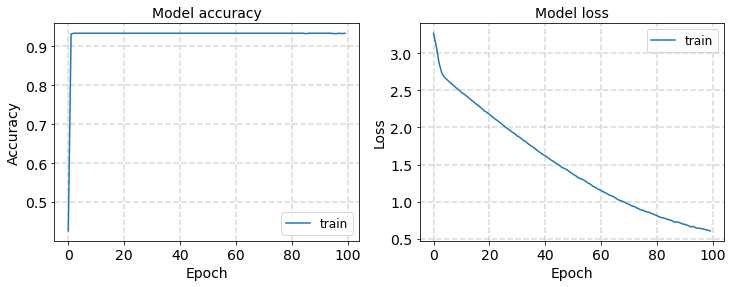

In [ ]:
# plotting accuracy and loss 
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(history.history['accuracy'])
#ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy', fontsize = 14)
ax[0].set_ylabel('Accuracy', fontsize = 14)
ax[0].set_xlabel('Epoch', fontsize = 14)
ax[0].tick_params(labelsize = 14)
ax[0].legend(['train', 'val'], loc='best', fontsize = 12)
ax[0].grid(True, lw = 1.5, ls = '--', color='gray', alpha = 0.3)

ax[1].plot(history.history['loss'])
#ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss', fontsize = 14)
ax[1].set_ylabel('Loss', fontsize = 14)
ax[1].set_xlabel('Epoch', fontsize = 14)
ax[1].tick_params(labelsize = 14)
ax[1].legend(['train', 'val'], loc='best', fontsize = 12)
ax[1].grid(True, lw = 1.5, ls = '--', color='gray', alpha = 0.3)

***Examining Network performance***

In [ ]:
# get probabilities for each input of being in class 1
y_pred_proba = model_loan.predict(train_x) 

# convert probabilties to class using a 0.5 threshold
y_pred_class = [0 if y <0.5 else 1 for y in y_pred_proba]


# Calculate network accuracy
print(f'Accuracy on the training data for a single run is {accuracy_score(y_pred_class, train_y)}')

Accuracy on the training data for a single run is 0.934


***Sampling weights and biases from keras-tensorflow BNN***

In [ ]:
samples = generate_posterior_samples(model_loan, 1000)

In [ ]:
samples.shape

(1000, 1081)

***Saving the samples for transfer learning***

In [ ]:
np.save('BNN_samples_VAEAC_loan_3_30_30_1s', samples)

***Looking at Samples, Traceplots for first 10 weights***

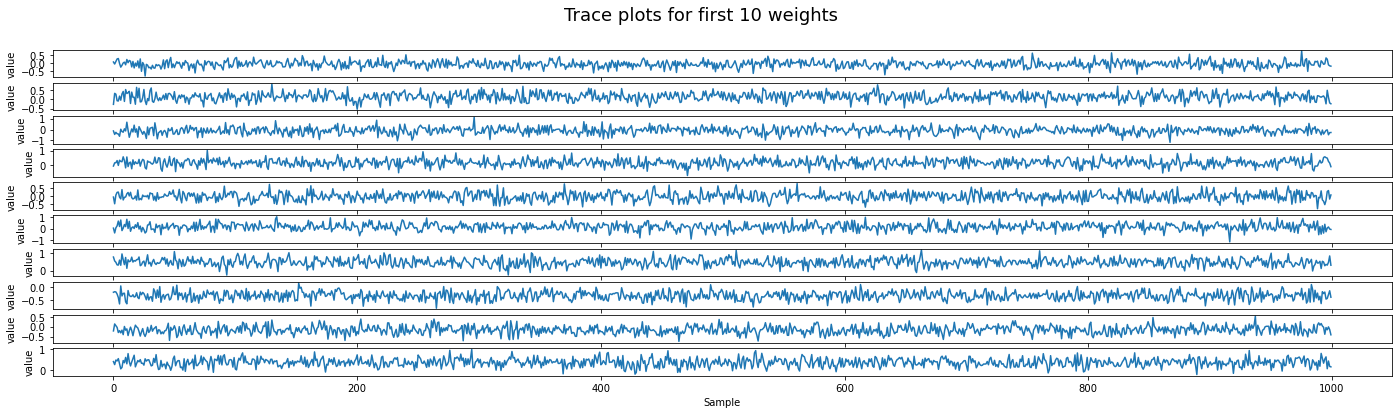

In [ ]:
fig, ax = plt.subplots(10, 1, figsize = (24, 6))
fig.suptitle('Trace plots for first 10 weights', fontsize=18)
for i in range(10):
    ax[i].plot(samples[:, i])
    ax[i].set_xlabel('Sample')
    ax[i].set_ylabel('value')
plt.show()

***Demonstrating the Transfer of weights to the NN built for CLUE with autograd***

In [ ]:
# Create a neural network instance and specify

###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

###neural network model design choices
width = [30, 30]  
input_dim = 3
output_dim = 1

# task = 'classify' or 'regress'
task = 'classify'

architecture = {'width': width,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn,
               'task':task}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward_flex(architecture, random=random)

***Recovering the keras-Tensorflow BNN Samples***

In [ ]:
samples = np.load('BNN_samples_VAEAC_loan_3_30_30_1s.npy')

In [ ]:
samples.shape

(1000, 1081)

***Getting 500 random samples (weights and biases) from the posterior samples from the TF BNN***


In [ ]:
indx = np.random.choice(range(samples.shape[0]), size=500, replace=False)
random_w_samples = samples[indx]

***Using sampled models to generate the posterior predictive of the training data with the Autograd NN***
* Here the weights and biases sampled from the TF BNN are fed into the Autograd NN and predictions are made


In [ ]:
# Crazy Autograd NN needs data flipped
x_t = train_x.T
y_t = train_y.reshape(1, -1)

In [ ]:
# post_probas_train will hold probability predictions for each model
# post_classes_train will hold class predictions for each model
# accuracies_train will hold the fraction correct of each model
post_probas_train = []
post_classes_train = []
accuracies_train = []

# Go through the randonly sampled models from smaples and make predictions with the Autograd NN
for sample in random_w_samples:
    y_probas = nn.predict_proba(sample.reshape(1, -1) , x_t)
    y_classes = nn.predict(sample.reshape(1, -1) , x_t)
    post_probas_train.append(y_probas)
    post_classes_train.append(y_classes)
    accuracies_train.append(accuracy_score(y_t.reshape(-1, 1), y_classes))
post_probas_train = np.array(post_probas_train)
post_classes_train = np.array(post_classes_train)

***Calculating mean model accuracy***

In [ ]:
print(f'mean accuracy of models on train data = {np.round(np.array(accuracies_train).mean(), 3)} ± {np.round(np.array(accuracies_train).std(), 3)}')

mean accuracy of models on train data = 0.934 ± 0.005


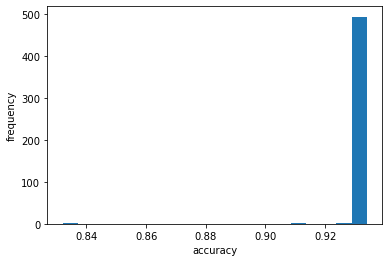

In [ ]:
### plotting a histogram of model accuracies
plt.figure(figsize = (6, 4))
plt.hist(accuracies_train, bins = 20)
plt.xlabel('accuracy')
plt.ylabel('frequency')
plt.show()

<a class='anchor' id='BNN2'></a>
### A BNN for the VAE-Generated Augmented Synthetic Loan  Datset (5 features)

***Loading and looking at data (10,000 datapoints, 5 features)***

In [28]:
path = f"{data_path}/FakeLoan_generated/"
train_x = pd.read_csv(path + 'gen_loan_train_x.csv')
train_x = train_x.drop('Unnamed: 0', axis=1).values
test_x = pd.read_csv(path + 'gen_loan_test_x.csv')
test_x = test_x.drop('Unnamed: 0', axis=1).values
train_y = pd.read_csv(path +'gen_loan_train_y.csv')
train_y = train_y.drop('Unnamed: 0', axis=1).values
test_y = pd.read_csv(path +'gen_loan_test_y.csv')
test_y = test_y.drop('Unnamed: 0', axis=1).values

In [ ]:
df_train = pd.DataFrame(np.hstack([train_x, train_y]), columns = (['fico', 'term',  'pti',  'ltv', 'age', 'default']))
df_train.head()

,fico,term,pti,ltv,age,default
0,771.38434,5.914379,0.062804,1.181167,45.652824,0.0
1,829.89020,5.815327,0.120413,1.221888,36.459377,0.0
2,607.40790,5.214087,0.130817,1.191535,37.548164,0.0
3,574.95490,6.137321,0.113409,1.124937,42.064750,1.0
4,446.36697,6.631861,0.158949,1.195639,52.985590,0.0


In [ ]:
scaler = StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [ ]:
train_x.shape

(10000, 5)

In [ ]:
train_y.shape

(10000, 1)

***Creating a BNN with  Keras in Tensorflow*** 

In [ ]:
# Building the network: 
# We learned the essentiasls of how to build this type of network in keras-tensorflow from:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py
tfp.layers.default_mean_field_normal_fn

NUM_TRAIN_EXAMPLES = 10000

kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p)/
                        tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

model_loan = tf.keras.models.Sequential([
  tfp.layers.DenseFlipout(
      30, kernel_divergence_fn=kl_divergence_function, bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular=False),
      activation=tf.nn.relu, input_shape=(5,)),
  tfp.layers.DenseFlipout(
      30, kernel_divergence_fn=kl_divergence_function, bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular=False),
      activation=tf.nn.relu),
  tfp.layers.DenseFlipout(1, kernel_divergence_fn=kl_divergence_function, bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular=False),
      activation='sigmoid')
])

# Compiling the network.
optimizer = tf.keras.optimizers.Adam(lr=.001)
model_loan.compile(optimizer, loss='binary_crossentropy',
            metrics=['accuracy'])
model_loan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_flipout_6 (DenseFlipou (None, 30)                360       
_________________________________________________________________
dense_flipout_7 (DenseFlipou (None, 30)                1860      
_________________________________________________________________
dense_flipout_8 (DenseFlipou (None, 1)                 62        
Total params: 2,282
Trainable params: 2,282
Non-trainable params: 0
_________________________________________________________________


***Training the BNN via Variational inference*** 

In [ ]:
history = model_loan.fit(x=train_x,
        y=train_y,
        batch_size=32,
        epochs=200)

Epoch 1/200
313/313 [==============================] - 0s 625us/step - loss: 0.6923 - accuracy: 0.7973
Epoch 2/200
313/313 [==============================] - 0s 639us/step - loss: 0.5651 - accuracy: 0.8243
Epoch 3/200
313/313 [==============================] - 0s 654us/step - loss: 0.5287 - accuracy: 0.8379
Epoch 4/200
313/313 [==============================] - 0s 650us/step - loss: 0.5019 - accuracy: 0.8351
Epoch 5/200
313/313 [==============================] - 0s 598us/step - loss: 0.4817 - accuracy: 0.8381
Epoch 6/200
313/313 [==============================] - 0s 592us/step - loss: 0.4626 - accuracy: 0.8363
Epoch 7/200
313/313 [==============================] - 0s 601us/step - loss: 0.4491 - accuracy: 0.8367
Epoch 8/200
313/313 [==============================] - 0s 599us/step - loss: 0.4383 - accuracy: 0.8387
Epoch 9/200
313/313 [==============================] - 0s 621us/step - loss: 0.4262 - accuracy: 0.8373
Epoch 10/200
313/313 [==============================] - 0s 641us/step - l

313/313 [==============================] - 0s 651us/step - loss: 0.2945 - accuracy: 0.8744
Epoch 80/200
313/313 [==============================] - 0s 614us/step - loss: 0.2910 - accuracy: 0.8749
Epoch 81/200
313/313 [==============================] - 0s 608us/step - loss: 0.2904 - accuracy: 0.8784
Epoch 82/200
313/313 [==============================] - 0s 669us/step - loss: 0.2917 - accuracy: 0.8756
Epoch 83/200
313/313 [==============================] - 0s 654us/step - loss: 0.2910 - accuracy: 0.8778
Epoch 84/200
313/313 [==============================] - 0s 691us/step - loss: 0.2908 - accuracy: 0.8750
Epoch 85/200
313/313 [==============================] - 0s 667us/step - loss: 0.2918 - accuracy: 0.8769
Epoch 86/200
313/313 [==============================] - 0s 703us/step - loss: 0.2894 - accuracy: 0.8770
Epoch 87/200
313/313 [==============================] - 0s 729us/step - loss: 0.2910 - accuracy: 0.8748
Epoch 88/200
313/313 [==============================] - 0s 724us/step - loss:

313/313 [==============================] - 0s 717us/step - loss: 0.2737 - accuracy: 0.8777
Epoch 158/200
313/313 [==============================] - 0s 615us/step - loss: 0.2729 - accuracy: 0.8804
Epoch 159/200
313/313 [==============================] - 0s 614us/step - loss: 0.2708 - accuracy: 0.8819
Epoch 160/200
313/313 [==============================] - 0s 611us/step - loss: 0.2766 - accuracy: 0.8803
Epoch 161/200
313/313 [==============================] - 0s 613us/step - loss: 0.2730 - accuracy: 0.8779
Epoch 162/200
313/313 [==============================] - 0s 615us/step - loss: 0.2764 - accuracy: 0.8805
Epoch 163/200
313/313 [==============================] - 0s 611us/step - loss: 0.2735 - accuracy: 0.8793
Epoch 164/200
313/313 [==============================] - 0s 656us/step - loss: 0.2718 - accuracy: 0.8803
Epoch 165/200
313/313 [==============================] - 0s 654us/step - loss: 0.2748 - accuracy: 0.8774
Epoch 166/200
313/313 [==============================] - 0s 636us/ste

***Plotting model loss and accuracy per epoch***

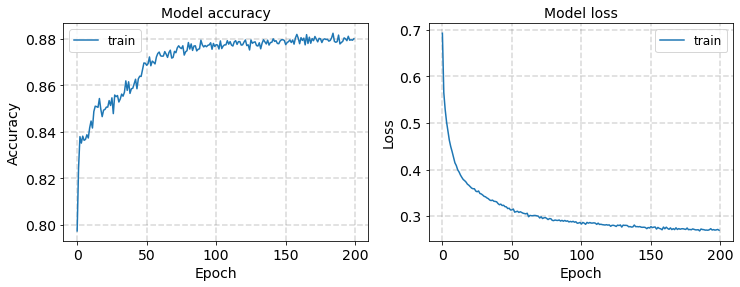

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(history.history['accuracy'])
ax[0].set_title('Model accuracy', fontsize = 14)
ax[0].set_ylabel('Accuracy', fontsize = 14)
ax[0].set_xlabel('Epoch', fontsize = 14)
ax[0].tick_params(labelsize = 14)
ax[0].legend(['train', 'val'], loc='best', fontsize = 12)
ax[0].grid(True, lw = 1.5, ls = '--', color='gray', alpha = 0.3)

ax[1].plot(history.history['loss'])
ax[1].set_title('Model loss', fontsize = 14)
ax[1].set_ylabel('Loss', fontsize = 14)
ax[1].set_xlabel('Epoch', fontsize = 14)
ax[1].tick_params(labelsize = 14)
ax[1].legend(['train', 'val'], loc='best', fontsize = 12)
ax[1].grid(True, lw = 1.5, ls = '--', color='gray', alpha = 0.3)

***Examining Network performance***

In [ ]:
# get class 1 probabilities for each input 
y_pred_proba = model_loan.predict(train_x) 

# convert probabilties to class using a 0.5 threshold
y_pred_class = [0 if y <0.5 else 1 for y in y_pred_proba]

# Calculate network accuracy
print(f'The model\'s accuracy on the training data is {accuracy_score(y_pred_class, train_y)}')

The model's accuracy on the training data is 0.8821


***Sampling weights and biases from keras-tensorflow BNN***

In [ ]:
### Generating 1000 samples of the model's posterior
samples = generate_posterior_samples(model_loan, 1000)

In [ ]:
samples.shape

(1000, 1141)

***Saving the samples for transfer learning***

In [ ]:
np.save('BNN_samples_VAE_loan_5_30_30_1s', samples)

***Looking at Samples, Traceplots for first 10 weights***

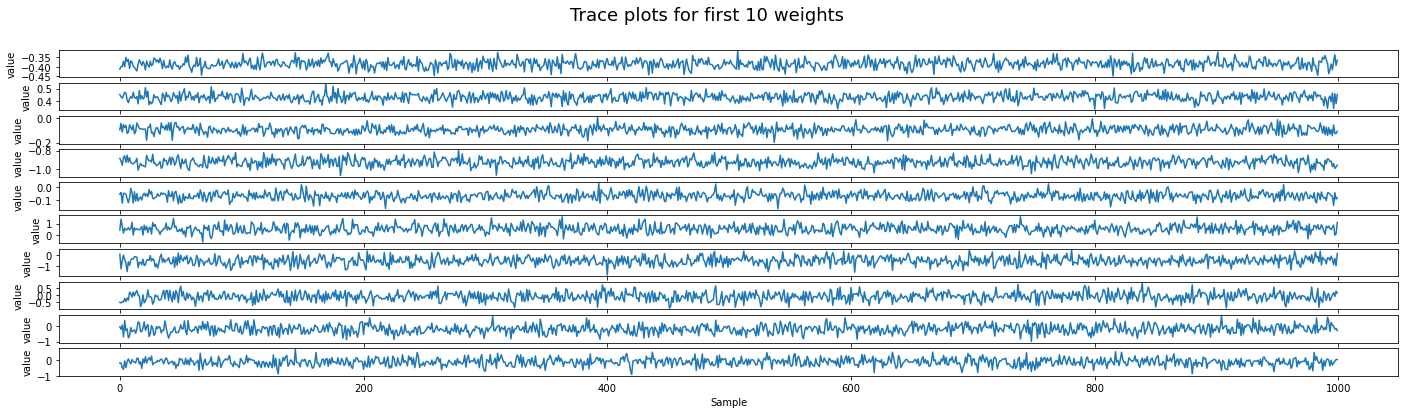

In [ ]:
fig, ax = plt.subplots(10, 1, figsize = (24, 6))
fig.suptitle('Trace plots for first 10 weights', fontsize=18)
for i in range(10):
    ax[i].plot(samples[:, i])
    ax[i].set_xlabel('Sample')
    ax[i].set_ylabel('value')
plt.show()

***Demonstrating the Transfer of weights to the NN built for CLUE with autograd***

In [ ]:
### Making an Autograd NN instance with the desried architecture (5-30-30-1)

###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

###neural network model design choices
width = [30, 30]  
input_dim = 5
output_dim = 1

# task = 'classify' or 'regress'
task = 'classify'

architecture = {'width': width,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn,
               'task':task}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward_flex(architecture, random=random)

***Recovering the keras-Tensorflow BNN Samples***

In [ ]:
samples = np.load('BNN_samples_VAE_loan_5_30_30_1s.npy')

In [ ]:
samples.shape

(1000, 1141)

***Getting 500 random samples (weights and biases) from the posterior samples from the TF BNN***

In [ ]:
indx = np.random.choice(range(samples.shape[0]), size=500, replace=False)
random_w_samples = samples[indx]

***Using sampled models to generate the posterior predictive of the training data with the Autograd NN***
* Here the weights and biases sampled from the TF BNN are fed into the Autograd NN and predictions are made

In [ ]:
# Crazy Autograd NN needs data flipped
x_t = train_x.T
y_t = train_y.reshape(1, -1)

In [ ]:
# post_probas_train will hold probability predictions for each model
# post_classes_train will hold class predictions for each model
# accuracies_train will hold the fraction correct of each model
post_probas_train = []
post_classes_train = []
accuracies_train = []

# Go through the randonly sampled models from smaples and make predictions with the Autograd NN
for sample in random_w_samples:
    y_probas = nn.predict_proba(sample.reshape(1, -1) , x_t)
    y_classes = nn.predict(sample.reshape(1, -1) , x_t)
    post_probas_train.append(y_probas)
    post_classes_train.append(y_classes)
    accuracies_train.append(accuracy_score(y_t.reshape(-1, 1), y_classes))
post_probas_train = np.array(post_probas_train)
post_classes_train = np.array(post_classes_train)

***Calculating mean model accuracy***

In [ ]:
print(f'mean accuracy of models on train data = {np.round(np.array(accuracies_train).mean(), 3)} ± {np.round(np.array(accuracies_train).std(), 3)}')

mean accuracy of models on train data = 0.881 ± 0.002


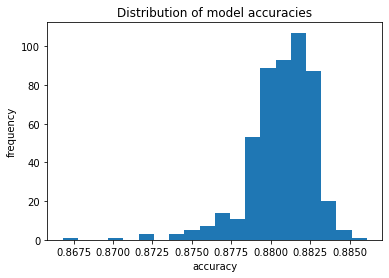

In [ ]:
### plotting a histogram of model accuracies
plt.figure(figsize = (6, 4))
plt.hist(accuracies_train, bins = 20)
plt.xlabel('accuracy')
plt.ylabel('frequency')
plt.title('Distribution of model accuracies')
plt.show()

<a class='anchor' id='BNN3'></a>
## A BNN for the VAE-generated COMPAS Dataset (6 features)

***Loading and looking at data***

In [29]:
path = f"{data_path}/COMPAS_generated/"
train_x = pd.read_csv(path +'gen_compas_train_x.csv')
train_x = train_x.drop('Unnamed: 0', axis=1).values
test_x = pd.read_csv(path +'gen_compas_test_x.csv')
test_x = test_x.drop('Unnamed: 0', axis=1).values
train_y = pd.read_csv(path +'gen_compas_train_y.csv')
train_y = train_y.drop('Unnamed: 0', axis=1).values
test_y = pd.read_csv(path +'gen_compas_test_y.csv')
test_y = test_y.drop('Unnamed: 0', axis=1).values

In [ ]:
df_train = pd.DataFrame(np.hstack([train_x, train_y]), columns = (['age', 'race', 'sex', 'priors_count', 'c_charge_degree',
       'days_served','two_year_recid' ]))
df_train.head()

,age,race,sex,priors_count,c_charge_degree,days_served,two_year_recid
0,42.297432,0.989538,0.999788,0.523008,0.001425,2.914387,0.0
1,21.815056,0.003711,0.997267,-0.066168,0.001860,1.303772,1.0
2,33.963608,1.002660,0.994385,1.187321,0.804268,0.613524,1.0
3,27.925790,0.001511,0.999817,2.113717,0.002235,2.785877,1.0
4,25.830725,-0.002826,0.614626,15.351144,0.995664,16.606804,1.0


In [ ]:
scaler = StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

***Creating a BNN with Keras-Tensorflow***

In [ ]:
NUM_CLASSES = 2
NUM_TRAIN_EXAMPLES = 10000

kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                        tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

model_compas = Sequential()
model_compas.add(tfp.layers.DenseFlipout(
      30, input_shape=(6,),kernel_divergence_fn=kl_divergence_function,
      activation=tf.nn.relu)),
model_compas.add(tfp.layers.DenseFlipout(
      30, kernel_divergence_fn=kl_divergence_function,
      activation=tf.nn.relu)),
model_compas.add(tfp.layers.DenseFlipout(
      1, kernel_divergence_fn=kl_divergence_function,
      activation='sigmoid'))

model_compas.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_flipout_18 (DenseFlipo (None, 30)                390       
_________________________________________________________________
dense_flipout_19 (DenseFlipo (None, 30)                1830      
_________________________________________________________________
dense_flipout_20 (DenseFlipo (None, 1)                 61        
Total params: 2,281
Trainable params: 2,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# set loss and optimizer and compile model
loss = tf.keras.losses.binary_crossentropy
optimizer = Adam(lr=0.001)
metrics = ['accuracy'] 
model_compas.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

***Training the BNN via Variational inference*** 

In [ ]:
# Fitting Model
history= model_compas.fit(train_x, train_y, batch_size = 32, validation_data = (test_x, test_y),epochs=150, verbose=2)

Epoch 1/150
313/313 - 0s - loss: 0.9321 - accuracy: 0.6014 - val_loss: 0.9007 - val_accuracy: 0.6400
Epoch 2/150
313/313 - 0s - loss: 0.8946 - accuracy: 0.6262 - val_loss: 0.8808 - val_accuracy: 0.6385
Epoch 3/150
313/313 - 0s - loss: 0.8739 - accuracy: 0.6316 - val_loss: 0.8654 - val_accuracy: 0.6400
Epoch 4/150
313/313 - 0s - loss: 0.8566 - accuracy: 0.6325 - val_loss: 0.8465 - val_accuracy: 0.6410
Epoch 5/150
313/313 - 0s - loss: 0.8414 - accuracy: 0.6315 - val_loss: 0.8338 - val_accuracy: 0.6340
Epoch 6/150
313/313 - 0s - loss: 0.8281 - accuracy: 0.6303 - val_loss: 0.8217 - val_accuracy: 0.6410
Epoch 7/150
313/313 - 0s - loss: 0.8169 - accuracy: 0.6291 - val_loss: 0.8151 - val_accuracy: 0.6390
Epoch 8/150
313/313 - 0s - loss: 0.8069 - accuracy: 0.6313 - val_loss: 0.8018 - val_accuracy: 0.6425
Epoch 9/150
313/313 - 0s - loss: 0.7996 - accuracy: 0.6337 - val_loss: 0.7979 - val_accuracy: 0.6255
Epoch 10/150
313/313 - 0s - loss: 0.7915 - accuracy: 0.6293 - val_loss: 0.7884 - val_accura

Epoch 82/150
313/313 - 0s - loss: 0.6791 - accuracy: 0.6332 - val_loss: 0.6824 - val_accuracy: 0.6355
Epoch 83/150
313/313 - 0s - loss: 0.6828 - accuracy: 0.6304 - val_loss: 0.6821 - val_accuracy: 0.6395
Epoch 84/150
313/313 - 0s - loss: 0.6790 - accuracy: 0.6358 - val_loss: 0.6809 - val_accuracy: 0.6380
Epoch 85/150
313/313 - 0s - loss: 0.6803 - accuracy: 0.6299 - val_loss: 0.6808 - val_accuracy: 0.6345
Epoch 86/150
313/313 - 0s - loss: 0.6799 - accuracy: 0.6317 - val_loss: 0.6811 - val_accuracy: 0.6330
Epoch 87/150
313/313 - 0s - loss: 0.6791 - accuracy: 0.6347 - val_loss: 0.6794 - val_accuracy: 0.6400
Epoch 88/150
313/313 - 0s - loss: 0.6779 - accuracy: 0.6316 - val_loss: 0.6824 - val_accuracy: 0.6370
Epoch 89/150
313/313 - 0s - loss: 0.6790 - accuracy: 0.6335 - val_loss: 0.6789 - val_accuracy: 0.6285
Epoch 90/150
313/313 - 0s - loss: 0.6803 - accuracy: 0.6343 - val_loss: 0.6777 - val_accuracy: 0.6450
Epoch 91/150
313/313 - 0s - loss: 0.6771 - accuracy: 0.6326 - val_loss: 0.6794 - v

***Plotting model loss and accuracy per epoch***

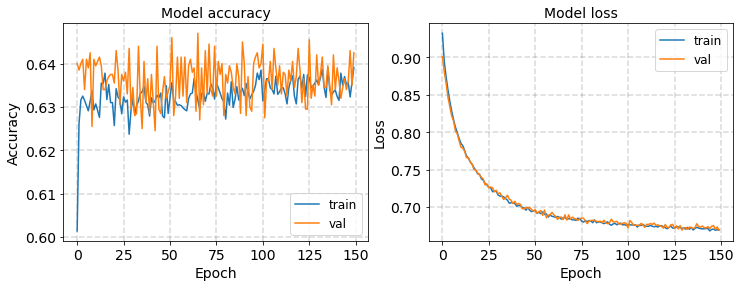

In [ ]:
# plotting accuracy and loss 
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy', fontsize = 14)
ax[0].set_ylabel('Accuracy', fontsize = 14)
ax[0].set_xlabel('Epoch', fontsize = 14)
ax[0].tick_params(labelsize = 14)
ax[0].legend(['train', 'val'], loc='best', fontsize = 12)
ax[0].grid(True, lw = 1.5, ls = '--', color='gray', alpha = 0.3)

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss', fontsize = 14)
ax[1].set_ylabel('Loss', fontsize = 14)
ax[1].set_xlabel('Epoch', fontsize = 14)
ax[1].tick_params(labelsize = 14)
ax[1].legend(['train', 'val'], loc='best', fontsize = 12)
ax[1].grid(True, lw = 1.5, ls = '--', color='gray', alpha = 0.3)

***Examining Network performance***

In [ ]:
# get probabilities for each input of being in class 1
y_pred_proba = model_compas.predict(train_x) 

# # convert probabilties to class using a 0.5 threshold
y_pred_class = [0 if p < 0.5 else 1 for p in y_pred_proba]

# Calculate network accuracy
print(f'Accuracy on training data is {accuracy_score(y_pred_class, train_y)}')

Accuracy on training data is 0.6364


***Sampling weights and biases from keras-tensorflow BNN***

In [ ]:
%%time
samples = generate_posterior_samples(model_compas, 1000)

CPU times: user 7min 44s, sys: 9.58 s, total: 7min 54s
Wall time: 1min 25s


In [ ]:
samples.shape

(1000, 1171)

***Saving the samples for transfer learning***

In [ ]:
np.save('BNN_samples_compas_6_30_30_1s', samples)

**Looking at Samples, Traceplots for first 10 weights***

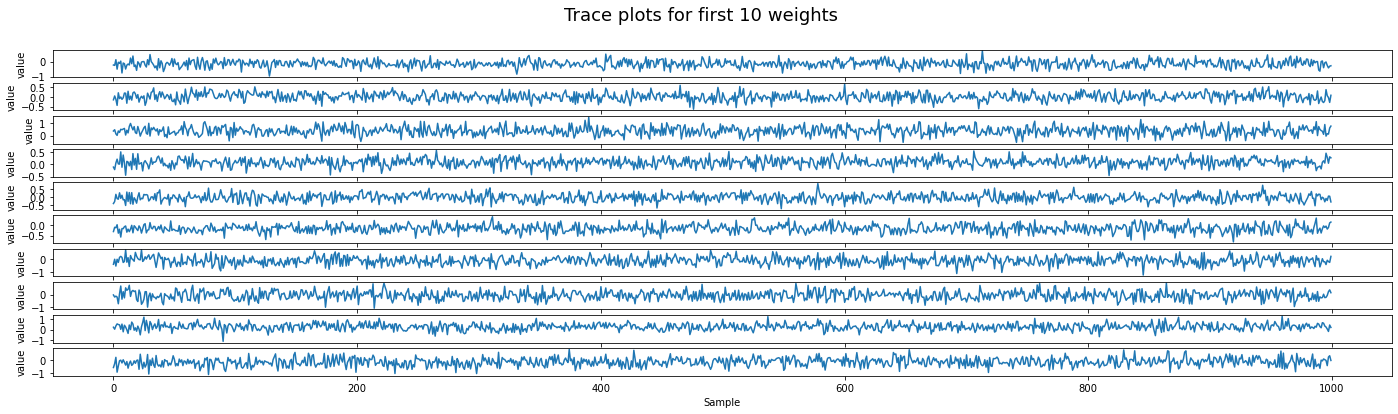

In [ ]:
fig, ax = plt.subplots(10, 1, figsize = (24, 6))
fig.suptitle('Trace plots for first 10 weights', fontsize=18)
for i in range(10):
    ax[i].plot(samples[:, i])
    ax[i].set_xlabel('Sample')
    ax[i].set_ylabel('value')
plt.show()

***Demonstrating the Transfer of weights to the NN built for CLUE with autograd***

In [ ]:
# Create a neural network instance and specify desired architecture

###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

###neural network model design choices
width = [30, 30] 
input_dim = 6
output_dim = 1

# task = 'classify' or 'regress'
task = 'classify'

architecture = {'width': width,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn,
               'task':task}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward_flex(architecture, random=random)

***Recovering the keras-Tensorflow BNN Samples***

In [ ]:
samples = np.load('BNN_samples_compas_6_30_30_1s.npy')

In [ ]:
samples.shape

(1000, 1171)

***Getting 500 random samples (weights and biases) from the posterior samples from the TF BNN***

In [ ]:
indx = np.random.choice(range(samples.shape[0]), size=1000, replace=False)
random_w_samples = samples[indx]

***Using sampled models to generate the posterior predictive of the training data with the Autograd NN***
* Here the weights and biases sampled from the TF BNN are fed into the Autograd NN and predictions are made

In [ ]:
x_t = train_x.T
y_t = train_y

In [ ]:
post_probas_train = []
post_classes_train = []
accuracies_train = []
for sample in random_w_samples:
    y_probas = nn.predict_proba(sample.reshape(1, -1) , x_t)
    y_classes = nn.predict(sample.reshape(1, -1) , x_t)
    post_probas_train.append(y_probas)
    post_classes_train.append(y_classes)
    accuracies_train.append(accuracy_score(y_t.reshape(-1, 1), y_classes))
post_probas_train = np.array(post_probas_train)
post_classes_train = np.array(post_classes_train)

***Calculating mean model accuracy***

In [ ]:
print(f'mean accuracy of models on train data = {np.round(np.array(accuracies_train).mean(), 3)} ± {np.round(np.array(accuracies_train).std(), 3)}')

mean accuracy of models on train data = 0.637 ± 0.004


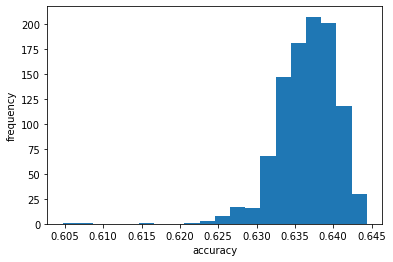

In [ ]:
plt.figure(figsize = (6, 4))
plt.hist(accuracies_train, bins = 20)
plt.xlabel('accuracy')
plt.ylabel('frequency')
plt.show()